## `Задание 01. Полносвязная нейронная сеть на numpy`

In [1]:
import numpy as np

### `Реализация нейронной сети`

В этом задании вы обучите полносвязную нейронную сеть распознавать рукописные цифры (а что же еще, если не их :), [почти] самостоятельно реализовав все составляющие алгоритма обучения и предсказания.

Для начала нам понадобится реализовать прямой и обратный проход через слои. Наши слои будут соответствовать следующему интерфейсу (на примере "тождественного" слоя):

In [2]:
class IdentityLayer:
    """
    A building block. Each layer is capable of performing two things:

    - Process input to get output:           
    output = layer.forward(input)

    - Propagate gradients through itself:    
    grad_input = layer.backward(input, grad_output)

    Some layers also have learnable parameters.

    Modified code from cs.hse DL course *
    """
    def __init__(self):
        """
        Here you can initialize layer parameters (if any) 
        and auxiliary stuff. You should enumerate all parameters
        in self.params
        """
        # An identity layer does nothing
        self.params = []
        pass

    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], 
        returns output data [batch, output_units]
        """
        # An identity layer just returns whatever it gets as input.
        self.input = input
        return input

    def backward(self, grad_output): 
        """
        Performs a backpropagation step through the layer, 
        with respect to the given input.

        To compute loss gradients w.r.t input, 
        you need to apply chain rule (backprop):

        d `loss` / d `input` = (d `loss` / d `layer`) * (d `layer` / d `input`)

        Luckily, you already receive d `loss` / d `layer` in argument, 
        so you only need to multiply it by d `layer` / d `input`.

        NB: Sometimes d `layer` / d `input` can be a 3D or even 4D tensor.
        So it's better to write down the `loss` differential and extract
        d `layer` / d `input` from it so that only 2D tensors were present.

        The method returns:
        * gradient w.r.t input (will be passed to 
          previous layer's backward method)
        * flattened gradient w.r.t. parameters (with .ravel() 
          applied to each gradient). 
          If there are no params, return []
        """
        # The gradient of an identity layer is precisely grad_output
        input_dim = self.input.shape[1]

        d_layer_d_input = np.eye(input_dim)

        return np.dot(grad_output, d_layer_d_input), [] # chain rule

```
I = W^{T} X = E^{T} X; dI / dX = E; dL / dX = (dL / dI) * (dI / dX)
```

#### `Слой нелинейности ReLU`

Для начала реализуем слой нелинейности $ReLU(y) = \max(0, y)$. Параметров у слоя нет. Метод `forward` должен вернуть результат поэлементного применения $ReLU$ к входному массиву, метод `backward` — градиент функции потерь по входу слоя. В нуле будем считать производную равной 0. Обратите внимание, что при обратном проходе могут понадобиться величины, посчитанные во время прямого прохода, поэтому их стоит сохранить как атрибут класса.

In [3]:
class ReLU:
    """
    Modified code from cs.hse DL course *
    """
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        self.params = [] # ReLU has no parameters

    def forward(self, input):
        """Apply elementwise ReLU to [batch, num_units] matrix"""
        ### your code here
        self.positive_mask = input > 0
        return self.positive_mask * input
        
    def backward(self, grad_output):
        """Compute gradient of loss w.r.t. ReLU input
        grad_output shape: [batch, num_units]
        output 1 shape: [batch, num_units]
        output 2: []
        """
        ### your code here
        
        return self.positive_mask.astype(np.float32) * grad_output, []
    
    def __repr__(self):
        return 'Relu()'

#### `Полносвязный слой`

Далее реализуем полносвязный слой без нелинейности. У слоя два параметра: матрица весов и вектор сдвига.

Обратите внимание на второй аргумент: в нем надо возвращать градиент по всем параметрам в одномерном виде. Для этого надо сначала применить `.ravel()` ко всем градиентам, а затем воспользоваться `np.r_`:

In [4]:
# example
np.r_[np.eye(3).ravel(), np.arange(4)]

array([1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 2., 3.])

In [5]:
class Dense:
    """
    Modified code from cs.hse DL course *
    """
    def __init__(self, input_units, output_units):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = x W + b
        """
        # initialize weights with small random numbers from normal distribution
        self.weights = np.random.randn(input_units, output_units) * 0.01
        self.biases = np.zeros(output_units)
        self.params = [self.weights, self.biases]

    def forward(self, input):
        """
        Perform an affine transformation:
        f(x) = x W + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        ### your code here
        self.input = input
        return input @ self.weights + self.biases[None, :]

    def backward(self, grad_output):
        """
        compute gradients
        grad_output shape: [batch, output_units]
        output shapes: [batch, input_units], [num_params]
        
        hint: use function np.r_
        np.r_[np.arange(3), np.arange(3)] = [0, 1, 2, 0, 1, 2]
        """
        ### your code here
        grad_b = np.sum(grad_output, axis=0)
        grad_W = np.dot(self.input.T, grad_output)
        grad_X = np.dot(grad_output, self.weights.T)
        
        return grad_X, np.r_[grad_W.ravel(), grad_b.ravel()]
        
    def __repr__(self):
        return f'Dense({self.weights.shape[0]}, {self.weights.shape[1]})'

```
y = x W + b [batch_size, n_out]
dL / dy [batch_size, n_out] — знаем
dL / db [n_out]

dy / dW = x
dL / dW = (dy/dW)^T dL / dy

dy / dx = W.T
dL / dx = dL / dy * (dy / dx)^{T} 
```

#### `Проверка градиента`

Проверим правильность реализации с помощью функции численной проверки градиента. Функция `eval_numerical_gradient` принимает на вход callable объект `f` (функцию от одного аргумента-матрицы) и аргумент `x` и вычисляет приближенный градиент функции `f` в точке `x`.

In [6]:
def eval_numerical_gradient(f, x, verbose=False, h=0.00001):
    """
    Evaluates gradient df/dx via finite differences:
    df/dx ~ (f(x+h) - f(x-h)) / 2h
    Adopted from https://github.com/ddtm/dl-course/
    """
    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print (ix, grad[ix])
        it.iternext() # step to next dimension

    return grad

Вычислите аналитический и численный градиенты по входу слоя ReLU от функции
$$ f(y) = \sum_i y_i, \quad y = ReLU(x) $$

Выпишите аналитический градиент в этой ячейке:

...

Следующая ячейка после заполнения должна не выдавать ошибку :)

In [ ]:
relu = ReLU()
points = np.linspace(-1, 1, 10*12).reshape([10, 12])

### your code here
### grads = 
### numeric_grads = 

assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

Вычислите аналитический и численный градиенты по входу полносвязного слоя от функции
$$ f(y) = \sum_i y_i, \quad y = W x + b $$

Выпишите аналитический градиент в этой ячейке (советуем выписать градиент через дифференциал функции $f$):

...

Следующая ячейка после заполнения должна не выдавать ошибку :)

In [8]:
linear = Dense(12, 32)
points = np.linspace(-1, 1, 10*12).reshape([10, 12])

### your code here
### grads = 
### numeric_grads = 

assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

#### `Реализация softmax-слоя и функции потерь`

Для решения задачи многоклассовой классификации обычно используют $softmax$ в качестве нелинейности на последнем слое, чтобы получить вероятности классов для каждого объекта:
$$\hat y = softmax(x)  = \left \{\frac {\exp(x^i)}{\sum_{j=1}^K \exp(x^j)} \right \}_{i=1}^K, \quad K - \text{число классов.}$$

Здесь за $x^i$ мы обозначаем $i$-ый признак объекта $x$.

В качестве функции потерь выберем отрицательный логарифм правдоподобия (по английски: negative log likelihood или NLL)
$$L(y, \hat y) = -\sum_{i=1}^K y^i \log \hat y^i,$$
где $y^i = 1$, если объект принадлежит $i$-му классу, и $y^i = 0$ иначе.

NLL совпадает с выражением для [кросс-энтропии](https://ru.wikipedia.org/wiki/Перекрёстная_энтропия) (в качестве первого распределения берем вырожденное распределение $y$, в качестве второго — предсказанное распределение $\hat y$). Очевидно, что эту функцию потерь также можно переписать через индексацию, если через $y$ обозначить класс данного объекта:
$$L(y, \hat y) = - \log \hat y_{y}$$

В таком виде ее удобно реализовывать.

Для обучения нейронной сети будем оптимизировать эту функцию потерь по параметрам нейронной сети:

$$ \frac1N \sum_{i=1}^N L(y_i, \hat y_i) = \frac1N \sum_{i=1}^N L(y_i, \text{NN}(x_i)) \rightarrow \min_{w}\,,$$
где за $x_i$ и $y_i$ мы обозначили признаки и таргет $i$-ого объекта обучающей выборки, за $\text{NN}$ мы обозначили нейронную сеть, которая по признакам объекта $x_i$ выдает распределение вероятностей $\hat y_i$, за $w$ мы обозначили все веса нейронной сети, а $N$ — это число объектов в обучающей выборке.

Реализуйте слой `LogSoftmax` (у этого слоя нет параметров). Метод `forward` должен вычислять логарифм от $softmax$, а метод `backward` — пропускать градиенты. В общем случае в промежуточных вычислениях `backward` получится трехмерный тензор, однако для нашей конкретной функции потерь все вычисления можно реализовать в матричном виде.  Поэтому мы будем предполагать, что аргумент `grad_output` — это матрица, у которой в каждой строке только одно ненулевое значение (не обязательно единица).

In [8]:
from scipy.special import logsumexp
# use this function instead of np.log(np.sum(np.exp(...))) because it is more stable

In [7]:
class LogSoftmax:
    def __init__(self):
        self.params = []

    def forward(self, input):
        """
        Applies softmax to each row and then applies component-wise log
        Input shape: [batch, num_units]
        Output shape: [batch, num_units]
        """
        ### your code here
        from scipy.special import log_softmax
        self.log_softmax = log_softmax(input, axis=1)
        return self.log_softmax
        
    def backward(self, grad_output):
        """
        Propagartes gradients.
        Assumes that each row of grad_output contains only 1 
        non-zero element
        Input shape: [batch, num_units]
        Output shape: [batch, num_units]
        Do not forget to return [] as second value (grad w.r.t. params)
        """
        ### your code here
        grad_X = grad_output - np.exp(self.log_softmax) * np.sum(grad_output, axis=1)[:, None]
        return grad_X, []
    
    def __repr__(self):
        return 'LogSoftmax()'

$$
LSM(x_{i}) = \log \frac{e^{x_{i}}}{\sum\limits_{j} e^{x_{j}}} = x_{i} - \log \sum\limits_{j} e^{x_{j}} = \log p(y == y_{i})
$$

$$
dLSM(x)_{i} / d x_{k} = I[i == k] - \frac{1}{\sum\limits_{j} e^{x_{j}}} e^{x_{k}} = I[i == k] - SM(x)_{k}
$$

$$
dLSM(x) / d x = I - SM(x)
$$

Реализуйте функцию потерь и градиенты функции потерь. Во время вычисления NLL усредняйте (а не суммируйте) значения функции потерь по батчу. Обычно так делают для того, чтобы при двух запусках обучения нейронной сети с разными размерами батча получаемые значения функции потерь у этих сетей были сравнимы.

In [8]:
def NLL(activations, target):
    """
    Returns negative log-likelihood of target under model represented by
    activations (log probabilities of classes, it's just output of LogSoftmax layer).
    `activations` has shape [batch, num_classes], `target` has shape [batch]
    Output shape: 1 (scalar).
    """
    ### your code here
    return -np.mean(activations[np.arange(len(target)), target])

def grad_NLL(activations, target):
    """
    Returns gradient of negative log-likelihood w.r.t. activations.
    each arg has shape [batch, num_classes]
    output shape: [batch, num-classes]
    """
    ### your code here
    return (
        -(np.arange(activations.shape[1])[None, :] == target[:, None]).astype(np.float32) / activations.shape[0]
    )

Наконец, выполните проверку `LogSoftmax`-слоя, используя функцию потерь и ее градиент:

In [ ]:
lsm = LogSoftmax()
target = np.arange(10)
points = np.linspace(-1, 1, 10 * 12).reshape([10, 12])

### your code here
### grads = 
### numeric_grads = 

assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

### `Загрузка данных`

Мы реализаовали все архитектурные составляющие нашей нейронной сети. Осталось загрузить данные и обучить модель. Мы будем работать с датасетом `digits`, каждый объект в котором — это 8x8 изображение рукописной цифры.

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
from sklearn.datasets import load_digits

In [11]:
X, y = load_digits(return_X_y=True)

In [12]:
X.shape, y.shape

((1797, 64), (1797,))

Разделим данные на обучение и контроль:

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [15]:
X_train.shape, X_test.shape

((1347, 64), (450, 64))

(<matplotlib.image.AxesImage at 0x132eaffd0>, 2)

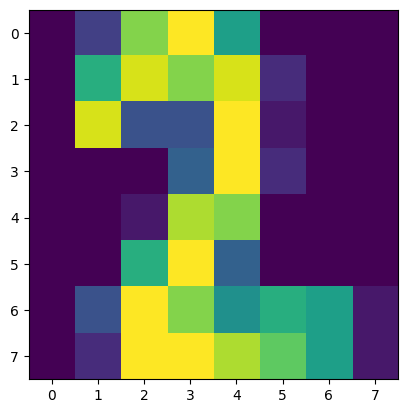

In [16]:
plt.imshow(X_train[0].reshape(8, 8)), y_train[0]

### `Сборка и обучение нейронной сети`

В нашей реализации мы представляем нейронную сеть в виде списка ее слоев. Например, следующая функция конструирует нейронную сеть заданной ширины (то есть с заданным размером скрытых слоев) и глубины (то есть с заданным количеством слоев) с заданным размером входа и выхода, а также с заданной функцией активации между линейными слоями.

In [17]:
def make_network(input_size, hidden_layers_size, output_size, n_layers=3, activation_class=ReLU):
    network = []

    for layer_idx in range(n_layers):
        # Compute sizes of current linear layer
        layer_in = input_size if layer_idx == 0 else hidden_layers_size
        layer_out = output_size if layer_idx == n_layers - 1 else hidden_layers_size
        
        # Add linear layer to the network
        network.append(Dense(layer_in, layer_out))

        # Add activation after each layer except the last one
        if layer_idx != n_layers - 1:
            network.append(activation_class())

    # Add LogSoftmax layer to the network
    network.append(LogSoftmax())

    return network

In [19]:
input_size = X_train.shape[1]
hidden_layers_size = 32
output_size = 10

network = make_network(input_size, hidden_layers_size, output_size, 3, ReLU)
network

[Dense(64, 32), Relu(), Dense(32, 32), Relu(), Dense(32, 10), LogSoftmax()]

Реализуйте функцию, которая выполнет прямой проход по нейронной сети:

In [20]:
def forward(network, X):
    """
    Perform forward pass through the network.
    
    network: list of layers
    X: raw data
    X shape: [batch, features_num]

    output: 
    output shape: [batch, out_features_num]
    """
    ### your code here
    for layer in network:
        X = layer.forward(X)
        
    return X

Для проверки, хорошо ли сеть обучилась, нам понадобится вычислять долю правильных ответов (accuracy) на данной выборке. Для этого реализуйте функцию, которая делает предсказания на каждом объекте (логично в качестве предсказания на очередном объекте выдавать тот класс, для которого предсказанный логарифм вероятности максимален):

In [21]:
def predict(network, X):
    """
    Returns predictions for each object in X.
    
    network: list of layers
    X: raw data
    X shape: [batch, features_num]

    output: array of classes, each from 0 to 9
    output shape: [batch]
    """
    ### your code here
    logits = forward(network, X)
    
    return np.argmax(logits, axis=1)

Мы будем обучать параметры нейросети с помощью готовой функции оптимизации из модуля `scipy`:

In [22]:
from scipy.optimize import minimize

In [23]:
help(minimize)

Help on function minimize in module scipy.optimize._minimize:

minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.
    
    Parameters
    ----------
    fun : callable
        The objective function to be minimized.
    
            ``fun(x, *args) -> float``
    
        where ``x`` is a 1-D array with shape (n,) and ``args``
        is a tuple of the fixed parameters needed to completely
        specify the function.
    x0 : ndarray, shape (n,)
        Initial guess. Array of real elements of size (n,),
        where ``n`` is the number of independent variables.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (`fun`, `jac` and `hess` functions).
    method : str or callable, optional
        Type of solver.  Should be one of
    
            - 'Nelder-Mead' :ref:`(see he

Эта функция имеет стандартный интерфейс: нужно передать callable объект, который вычисляет значение и градиент целевой функции, а также точку старта оптимизации — начальное приближение (одномерный `numpy`-массив). Поэтому нам понадобятся функции для сбора и задания всех весов нашей нейросети (именно для них мы всегда записывали параметры слоя в список `layer.params`)

In [24]:
def get_weights(network):
    weights = []
    for layer in network:
        for param in layer.params:
            weights += param.ravel().tolist()
    return np.array(weights)


def set_weights(weights, network):
    i = 0
    for layer in network:
        for param in layer.params:
            l = param.size
            param[:] = weights[i:i+l].reshape(param.shape)
            i += l

Вам нужно реализовать ту самую функцию, которую мы будем передавать в `minimize`. Эта функция должна брать на вход текущую точку (вектор всех параметров), а также список дополнительных параметров (мы будем передавать через них нашу сеть и обучающие данные) и возвращать значение критерия качества (NLL) и его градиент по параметрам модели.

In [25]:
def compute_loss_grad(weights, args):
    """
    takes current weights and computes cross-entropy and gradients
    weights shape: [num_parameters]
    output 1: loss (scalar)
    output 2: gradint w.r.t. weights, shape: [num_parameters]
    
    hint: firstly perform forward pass through the whole network
    then compute loss and its gradients
    then perform backward pass, transmitting first baskward output
    to the previos layer and saving second baskward output in a list
    finally flatten all the gradients in this list
    (in the order from the first to the last layer)
    
    Do not forget to set weights of the network!
    """
    network, X, y = args
    ### your code here
    set_weights(weights, network)
    
    logits = forward(network, X)
    loss = NLL(logits, y)
    
    grad_weights = []
    
    grad_L = grad_NLL(logits, y)
    for layer in network[::-1]:
        grad_L, grad_params = layer.backward(grad_L)
        grad_weights.append(grad_params)
        
    return loss, np.hstack(grad_weights[::-1])

Теперь мы готовы обучать нашу нейросеть. 

In [26]:
weights = get_weights(network)

In [27]:
res = minimize(
    compute_loss_grad, weights,       # fun and start point
    args=[network, X_train, y_train], # args passed to fun
    method="L-BFGS-B",                # optimization method
    jac=True                          # says that gradient is computed in fun
)

In [28]:
res.keys()

dict_keys(['fun', 'jac', 'nfev', 'njev', 'nit', 'status', 'message', 'x', 'success', 'hess_inv'])

In [29]:
res["nit"] # number of iterations (should be >> 10)

109

In [30]:
res["success"] # should be True

True

In [31]:
res["x"] # leraned weights

array([ 0.01795882, -0.01102969, -0.00231158, ..., -0.89327645,
       -1.84760323, -0.35702128])

Выведите качество на обучении (`X_train`, `y_train`) и на контроле (`X_test`, `y_test`). Не забудьте установить веса!

In [32]:
### your code here
set_weights(res['x'], network)
print("Cross Entropy (Train/Test): {0:.3f}/{1:.3f}".format(
    NLL(forward(network, X_train), y_train),
    NLL(forward(network, X_test), y_test)
))

print("Accuracy (Train/Test): {0:.3f}/{1:.3f}".format(
    np.mean(predict(network, X_train) == y_train),
    np.mean(predict(network, X_test) == y_test)
))

Cross Entropy (Train/Test): 0.000/0.698
Accuracy (Train/Test): 1.000/0.953


У `minimize` есть также аргумент `callback` — в нее можно передать функцию, которая будет вызываться после каждой итерации оптимизации. Такую функцию удобно оформить в виде метода класса, который будет сохранять качество на обучении контроле после каждой итерации. Реализуйте этот метод в классе `Callback`:

In [33]:
class Callback:
    def __init__(self, network, X_train, y_train, X_test, y_test, print=False):
        self.network = network
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.print = print
        self.train_acc = []
        self.test_acc = []
        
    def call(self, weights):
        """
        Computes quality on train and test set with given weights
        and saves to self.train_acc and self.test_acc.
        If self.print is True, also prints these 2 values
        """
        ### your code here
        set_weights(weights, self.network)

        self.test_acc.append(np.mean(predict(self.network, self.X_test) == self.y_test))
        self.train_acc.append(np.mean(predict(self.network, self.X_train) == self.y_train))

In [34]:
cb = Callback(network, X_train, y_train, X_test, y_test, print=True)

res = minimize(
    compute_loss_grad, weights,  
    args=[network, X_train, y_train], 
    method="L-BFGS-B",
    jac=True,
    callback=cb.call
)

Изобразите на графике кривую качества на обучени и контроле по итерациям:

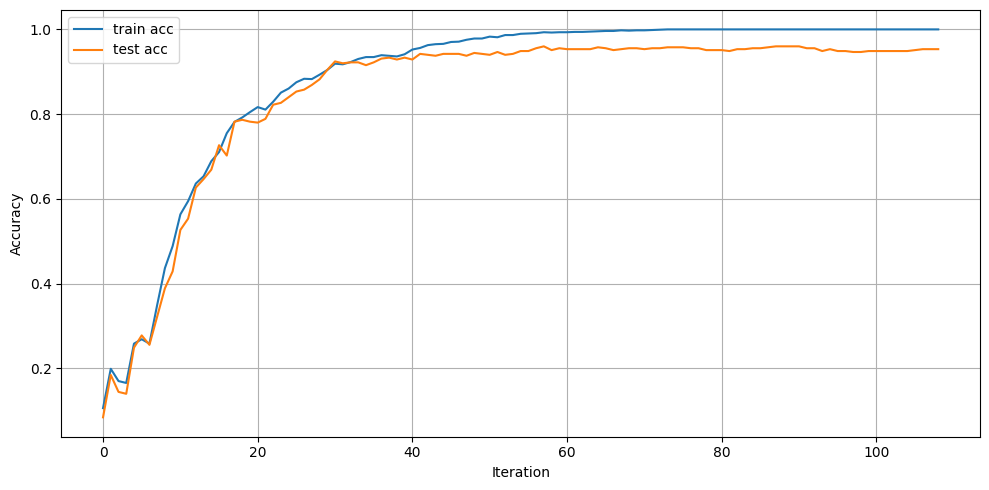

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(cb.train_acc, label="train acc")
ax.plot(cb.test_acc, label="test acc")
ax.set_xlabel("Iteration")
ax.set_ylabel("Accuracy")
ax.grid(True)
ax.legend()

fig.tight_layout()
plt.show()

### `Эксперименты с числом слоев`

Ясно, что из-за случайного начального приближения с каждым запуском обучения мы будем получать различное качество. Попробуем обучить нашу нейросеть с разным числом слоев несколько раз.

Заполните матрицы `accs_train` и `accs_test`. В позиции `[i, j]` должна стоять величина доли правильных ответов сети с $i+1$ полносвязными слоями при $j$-м запуске (все запуски идентичны).

In [38]:
accs_train = np.zeros((5, 5))
accs_test = np.zeros((5, 5))

In [39]:
### your code here

Построим боксплоты полученного качества (горизонтальная линия в каждом столбце — среднее, прямоугольник показывает разброс).

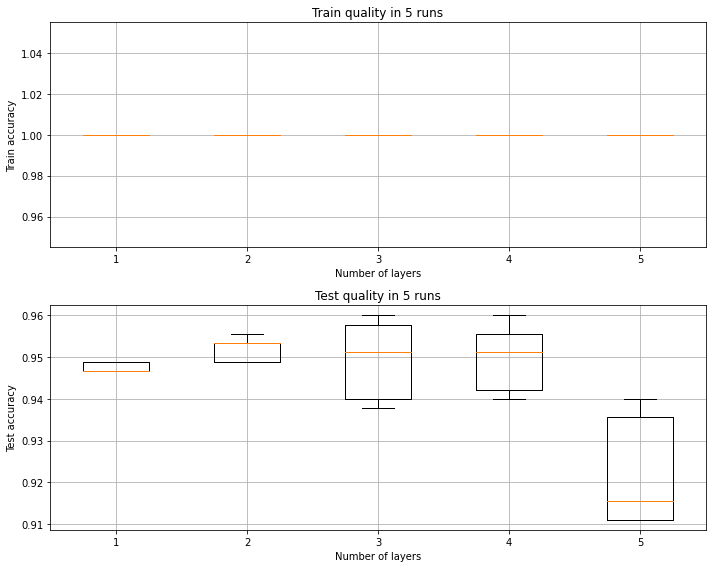

In [40]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

axes[0].boxplot(accs_train.T, showfliers=False)
axes[1].boxplot(accs_test.T, showfliers=False)

axes[0].set_xlabel("Number of layers")
axes[1].set_xlabel("Number of layers")

axes[0].set_ylabel("Train accuracy")
axes[1].set_ylabel("Test accuracy")

axes[0].set_title("Train quality in 5 runs")
axes[1].set_title("Test quality in 5 runs")

axes[0].grid(True)
axes[1].grid(True)

fig.tight_layout()
plt.show()

Дайте развёрнутый ответ на вопросы (в этой же ячейке):
* Как изменяются качество на обучении и контроле и устойчивость процесса обучения при увеличении числа слоев?
* Можно ли сказать, что логистическая регрессия (линейная модель) дает качество хуже, чем нелинейная модель?

__Ответы:__

...

### `Эксперименты c различными инициализациями весов`

Как уже было сказано, начальная инициализация весов нейронной сети может сильно влиять на процесс ее обучения и, как следствие, на ее качество.

В этом пункте вам предлагается попробовать обучить несколько нейронных сетей с различными инициализациями слоев.

Для этого необходимо реализовать функцию, инициализирующую веса линейных слоёв нашей нейронной сети. Добавьте в функционал данного метода возможность инициализировать его веса с помощью инициализации Kaiming (используется, если в нейронной сети в качестве функций активации используется ReLU) и инициализации Xavier (используется, если в нейронной сети в качестве функций активации используется Tanh или Sigmoid):

In [41]:
def initialize_network(network, initialization):
    for layer in network:
        if isinstance(layer, Dense):
            input_units, output_units = layer.weights.shape
            if initialization == 'Kaiming':
                ### your code here
                pass
            elif initialization == 'Xavier':
                ### your code here
                pass
            else:
                # Initialize weights with small random numbers from normal distribution.
                # In this case `initialization` represents a standard deviation
                # for normal distribution.
                layer.weights = np.random.randn(input_units, output_units) * initialization
            layer.biases = np.zeros_like(layer.biases)
            
            layer.params = [layer.weights, layer.biases]

Теперь попробуйте для каждой из 3 инициализаций обучить нейронную сеть несколько раз. Попробуйте проделать данную операцию при зафиксированном числе слоев равным 3, 4 и 5.

#### `3 слоя`

Зафиксируйте в сети число слоев равное трем.

Заполните матрицы `accs_train` и `accs_test`. В позиции `[i, j]` должна стоять величина доли правильных ответов сети при $j$-м запуске (все запуски идентичны) с инициализацией Kaiming при $i = 3$, с инициализацией Xavier при $i = 4$ и с инициализацией из нормального распределения с фиксированными параметрами при $0 \leqslant i \leqslant 2$ (попробуйте здесь 3 разных параметра для стандартного отклонения для нормального распределения, например: `1e-3`, `1e-2`, `1e-1`). Заметьте, что при большом числе слоев слишком низкое стандартное отклонение может не давать нейронной сети нормально обучиться.

In [61]:
init_vars = [1e-3, 1e-2, 1e-1, 'Kaiming', 'Xavier']

In [62]:
accs_train = np.zeros((5, 5))
accs_test = np.zeros((5, 5))

In [63]:
### your code here

Построим боксплоты полученного качества (горизонтальная линия в каждом столбце — среднее, прямоугольник показывает разброс).

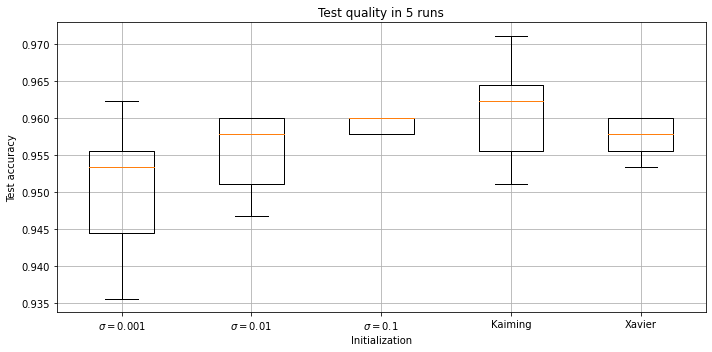

In [64]:
init_vars_for_plot = [(x if isinstance(x, str) else fr"$\sigma = {x}$") for x in init_vars]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.boxplot(accs_test.T, labels=init_vars_for_plot, showfliers=False)

ax.set_title("Test quality in 5 runs")
ax.set_xlabel("Initialization")
ax.set_ylabel("Test accuracy")
ax.grid(True)

fig.tight_layout()
plt.show()

#### `4 слоя`

Выполните тут тот же код, что и в предыдущем пункте, но только уже с 4 слоями в сети.

In [65]:
init_vars = [5e-3, 1e-2, 1e-1, 'Kaiming', 'Xavier']

In [66]:
accs_train = np.zeros((5, 5))
accs_test = np.zeros((5, 5))

In [67]:
### your code here

Построим боксплоты полученного качества (горизонтальная линия в каждом столбце — среднее, прямоугольник показывает разброс).

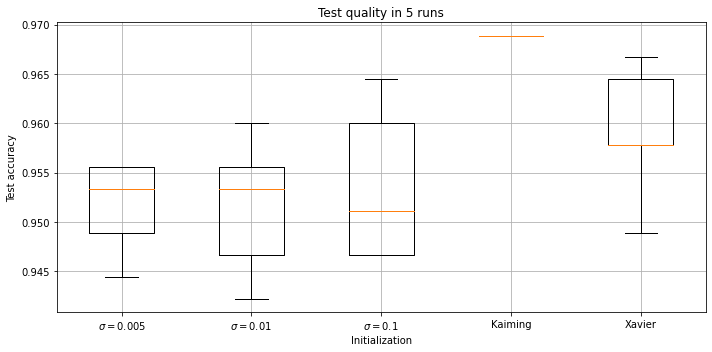

In [68]:
init_vars_for_plot = [(x if isinstance(x, str) else fr"$\sigma = {x}$") for x in init_vars]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.boxplot(accs_test.T, labels=init_vars_for_plot, showfliers=False)

ax.set_title("Test quality in 5 runs")
ax.set_xlabel("Initialization")
ax.set_ylabel("Test accuracy")
ax.grid(True)

fig.tight_layout()
plt.show()

#### `5 слоев`

Выполните тут тот же код, что и в предыдущем пункте, но только уже с 5 слоями в сети.

In [69]:
init_vars = [1e-2, 1e-1, 1e0, 'Kaiming', 'Xavier']

In [70]:
accs_train = np.zeros((5, 5))
accs_test = np.zeros((5, 5))

In [71]:
### your code here

Построим боксплоты полученного качества (горизонтальная линия в каждом столбце — среднее, прямоугольник показывает разброс).

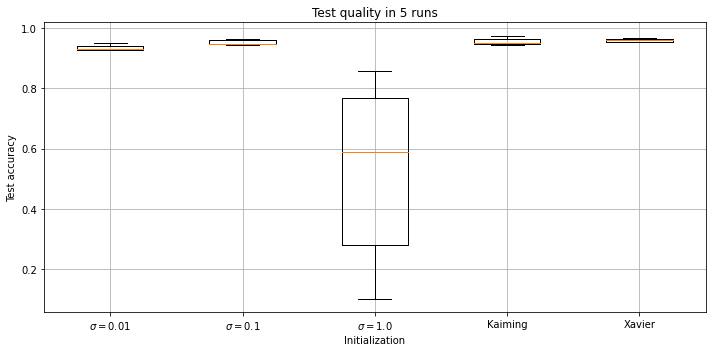

In [72]:
init_vars_for_plot = [(x if isinstance(x, str) else fr"$\sigma = {x}$") for x in init_vars]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.boxplot(accs_test.T, labels=init_vars_for_plot, showfliers=False)

ax.set_title("Test quality in 5 runs")
ax.set_xlabel("Initialization")
ax.set_ylabel("Test accuracy")
ax.grid(True)

fig.tight_layout()
plt.show()

Дайте развёрнутый ответ на вопросы (в этой же ячейке):
* Как отличаются качество на обучении и контроле и устойчивость процесса обучения при различных инициализациях?
* Какие инициализации помогают обучать более глубокие сети?

__Ответы:__

...

Теперь сравним скорость обучения при различных инициализациях. Создайте два списка списков `accs_test_on_iterations`, `accs_train_on_iterations` в каждом из которых в позиции `[i]` (см. описание `i` в предыдущем пункте) будет лежать список из значений `accuracy` на тестовой и обучающей выборках соотвественно, полученных во время обучения модели. Количество слоев в сети зафиксируйте равным 4.

In [75]:
init_vars = [1e-3, 1e-2, 1e-1, 'Kaiming', 'Xavier']

In [76]:
accs_test_on_iterations = []
accs_train_on_iterations = []

In [77]:
### your code here

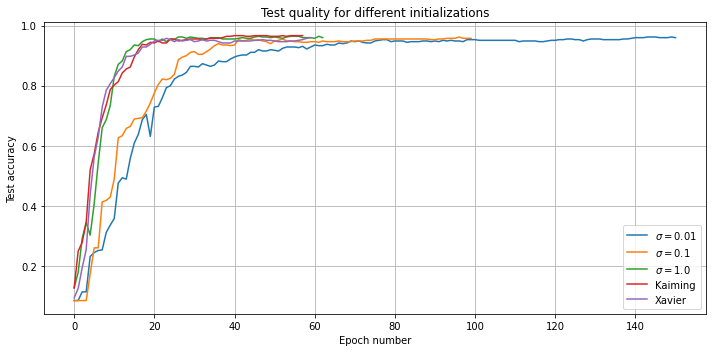

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for idx, label in enumerate(init_vars_for_plot):
    ax.plot(accs_test_on_iterations[idx], label=label)

ax.set_title("Test quality for different initializations")
ax.set_xlabel("Epoch number")
ax.set_ylabel("Test accuracy")
ax.grid(True)
ax.legend()

fig.tight_layout()
plt.show()

Дайте развёрнутый ответ на вопросы (в этой же ячейке):
* Как меняется скорость обучения в зависимости от выбранной инициализации?

__Ответы:__

...

### `Эксперименты c различными функциями активации`

Проверим теперь, с какой функцией активации нейронная сеть будет обучаться лучше.

В этом пункте вам предлагается попробовать обучить несколько нейронных сетей с различными функциями активации.

Для этого нам нужно реализовать еще 2 слоя: для функций активации `Tanh` и `Sigmoid`.

In [49]:
class Tanh:
    """
    tanh(y) = (e^y - e^(-y)) / (e^y + e^(-y))
    Используйте функцию np.tanh для подсчета гиперболического тангенса.
    Вы можете сами реализовать подсчет tanh, но тогда вам нужно устойчиво его вычислять.
    """
    def __init__(self):
        self.params = [] # Tanh has no parameters

    def forward(self, input):
        """
        Apply elementwise Tanh to [batch, num_units] matrix
        """
        ### your code here

    def backward(self, grad_output):
        """
        Compute gradient of loss w.r.t. Tanh input
        grad_output shape: [batch, num_units]
        output 1 shape: [batch, num_units]
        output 2: []
        """
        ### your code here

    def __repr__(self):
        return 'Tanh()'

In [50]:
from scipy.special import expit
    
class Sigmoid:
    """
    sigmoid(y) = 1 / (1 + e^(-y))
    Используйте функцию expit для подсчета сигмоиды.
    Вы можете сами реализовать подсчет сигмоиды, но тогда вам нужно устойчиво ее вычислять.
    """
    def __init__(self):
        self.params = [] # Sigmoid has no parameters

    def forward(self, input):
        """
        Apply elementwise Sigmoid to [batch, num_units] matrix
        """
        ### your code here

    def backward(self, grad_output):
        """
        Compute gradient of loss w.r.t. Sigmoid input
        grad_output shape: [batch, num_units]
        output 1 shape: [batch, num_units]
        output 2: []
        """
        ### your code here

    def __repr__(self):
        return 'Sigmoid()'

Теперь попробуйте для каждой из 3 функций активации обучить нейронную сеть несколько раз. Число слоев зафиксируйте равным 3. В случае `Tanh` и `Sigmoid` используйте инициализацию `Xavier`, а в случае `ReLU` используйте инициализацию `Kaiming`.

Заполните матрицы `accs_train` и `accs_test`. В позиции `[i, j]` должна стоять величина доли правильных ответов сети при $j$-м запуске (все запуски идентичны) с функцией активации $ReLU$ при $i = 0$, с функцией активации $Tanh$ при $i = 1$ и с функцией активации $Sigmoid$ при $i = 2$.

In [51]:
act_func_vars = ['Tanh', 'Sigmoid', 'ReLU']
init_for_act_funcs = ['Xavier', 'Xavier', 'Kaiming']

In [52]:
accs_train = np.zeros((3, 5))
accs_test = np.zeros((3, 5))

In [53]:
### your code here

Построим боксплоты полученного качества (горизонтальная линия в каждом столбце — среднее, прямоугольник показывает разброс).

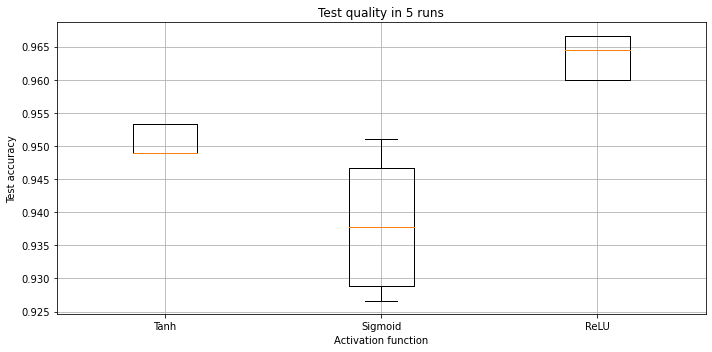

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.boxplot(accs_test.T, labels=act_func_vars, showfliers=False)

ax.set_title("Test quality in 5 runs")
ax.set_xlabel("Activation function")
ax.set_ylabel("Test accuracy")
ax.grid(True)

fig.tight_layout()
plt.show()

Дайте развёрнутый ответ на вопросы (в этой же ячейке):
* Как отличаются качество на обучении и контроле и устойчивость процесса обучения при различных функциях активации?

__Ответы:__

...

\* Несколько фрагментов кода в задании написаны на основе материалов [курса по глубинному обучению на ФКН НИУ ВШЭ](https://www.hse.ru/ba/ami/courses/205504078.html)